<a href="https://colab.research.google.com/github/RaduW/volume-rebalance/blob/main/volume_rebalancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Volume Rebalancing Algorithm


The volume rebalancing algorithm is based on the assumption that while given a global sample rate classes we want to adjust the individual class sampling rate in a way that equalises the number of sampled elements in each class while maintaining the overall sample rate.

In [117]:
from operator import itemgetter

from ipywidgets import interact, widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [118]:
# import transaction data
projects = "https://raw.githubusercontent.com/RaduW/volume-rebalance/main/projects.json"
trans_data = pd.read_json(projects)

In [119]:
import operator
from collections import namedtuple
from copy import copy
from typing import List, Mapping, MutableMapping, Tuple, Union


def adjust_sample_rate(
    transactions: List[Tuple[str, int]], rate: float) -> Mapping[str, float]:
    """
    Calculates transaction sample size in order to maximize the number of small transactions

    :param transactions: the transaction types as an array of (name, count) tuples
    :param rate: the overall desired rate
    """
    # sort by transaction count
    transactions = sorted(transactions, key=operator.itemgetter(1))
    return adjust_sample_rate_full(transactions, rate)


def adjust_sample_rate_full(
    transactions: List[Tuple[str, int]], rate: float
) -> MutableMapping[str, float]:
    """
    resample all transactions to their ideal size
    """
    transactions = copy(transactions)
    ret_val = {}
    num_transactions = total_transactions(transactions)
    # calculate how many transactions we are allowed to keep overall
    # this will allow us to pass transactions between different transaction types
    total_budget = num_transactions * rate
    while transactions:
        num_types = len(transactions)
        # We recalculate the budget per type every iteration to
        # account for the cases where, in the previous step we couldn't
        # spend all the allocated budget for that type.
        budget_per_transaction_type = total_budget / num_types
        name, count = transactions.pop(0)
        if count < budget_per_transaction_type:
            # we have fewer transactions in this type than the
            # budget, all we can do is to keep everything
            ret_val[name] = 1.0  # not enough samples, use all
            total_budget -= count
        else:
            # we have enough transactions in current the class
            # we want to only keep budget_per_transactions
            transaction_rate = budget_per_transaction_type / count
            ret_val[name] = transaction_rate
            total_budget -= budget_per_transaction_type
    return ret_val

def total_transactions(transactions: List[Tuple[str, int]]) -> int:
    ret_val = 0
    for _, v in transactions:
        ret_val += v
    return ret_val
    
def counts_to_labeled_counts( counts: Union[float,int,Tuple[str,float]]):
  counts = sorted(counts)
  return [(f"t-{idx}",count) for idx,count in enumerate(counts)]

# Model params

The model has the following input parameters:

*   a list of initial counts representing the number of elements for each class `counts`
*   an overall desired sample rate: `global_rate` (input via slider)



In [120]:


def process_data(global_rate, transactions:List[Tuple[str,float]]):

    transactions = sorted(transactions,key=itemgetter(1))
    counts = [cnt[1] for cnt in transactions]

    cnts = np.array(counts)
    ideal_rate = np.average(cnts) * global_rate
    cnts_min = cnts.min()
    cnts_max = cnts.max()

    labels = [ x[0] for x in transactions]

    sampled_counts = cnts * global_rate

    original_df = pd.DataFrame(data ={"counts": cnts, "original": sampled_counts}, index = labels)
    adjusted = adjust_sample_rate(transactions, global_rate)
    adjusted_df = pd.DataFrame.from_dict(data = adjusted, orient="index", columns=["adjusted_rate"] )

    # now calculate the adjusted count
    df = original_df.join(adjusted_df, how="outer")

    df["adjusted"] = df["counts"]* df["adjusted_rate"]
    return df  

def draw_rebalance_graphs(global_rate, items_high, items_low, counts):

    def draw_plot(ax, x_limit=None, log=False):
      if x_limit is not None:
        ax.set_xlim(*x_limit)
        data = df2[df2["counts"]<x_limit[1]]

      else:
        data= df2

      if log:
        plt.xscale("log")
        plt.yscale("log")
      else:
        plt.xscale("linear")
        plt.yscale("linear")


      counts_series = data["counts"]

      cnts_min = counts_series.min()
      cnts_max =  counts_series.max()
      ideal_rate = counts_series.mean() * global_rate
      rate_max = data.rate.max()

      if not log:
        sns.lineplot( x=[cnts_min, cnts_max+1], y=[ideal_rate,ideal_rate], ax = ax);
        sns.lineplot( x=[last_low,last_low+1], y=[0, rate_max], color="blue", ax=ax);
        sns.lineplot( x=[first_high,first_high+1], y=[0, rate_max], color="red", ax=ax, );

      sns.scatterplot(data=data, x="counts", y="rate", hue ="series", style="series", ax=ax)


    df = process_data(global_rate, counts)

    counts_series = df["counts"]

    last_low = counts_series.iloc[items_low]
    first_high = counts_series.iloc[-items_high]

    df2 = df.melt(id_vars=["counts"],value_vars=["adjusted","original"], var_name="series", value_name = "rate")
    fig, ax = plt.subplots(nrows = 4 ,figsize=(20,20))

    draw_plot(ax[0])
    draw_plot(ax[1], x_limit=(-50,1050))
    draw_plot(ax[2], x_limit=(-20, 220))
    draw_plot(ax[3], log=True)





### Counts

In [121]:
trans_data.head()

,name,freq
0,/,42.787500
1,/*,4.945833
2,/*/*/except,0.241667
3,/.*/,11.579167
4,/_admin/,0.025000


In [122]:
counts = [10,500.37,  3999.88, 7000, 9000]
counts = counts_to_labeled_counts(counts)

# override counts with real transaction data
# multipy the freq by 1000 to make it easyer to display ()
trans_data['freq'] = trans_data['freq']
counts = list(trans_data.itertuples(index=False, name=None))
num_transactions = len(counts)
num_transactions

568

### Sample rate

In [123]:
global_rate=widgets.FloatSlider(min=0,max=1,value=0.1, step=0.001 );
items_high=widgets.IntSlider(min=0,max=num_transactions,value=20);
items_low=widgets.IntSlider(min=0,max=num_transactions,value=20);

def rebalance_generator(counts):
  def inner( global_rate, items_high, items_low):
    draw_rebalance_graphs(global_rate, items_high,items_low, counts)
  return inner

widgets.interact(rebalance_generator(counts), global_rate = global_rate, items_high=items_high, items_low=items_low);

interactive(children=(FloatSlider(value=0.1, description='global_rate', max=1.0, step=0.001), IntSlider(value=…

In [124]:
print(f"Global Rate is {global_rate.value}")
adjusted_rates = process_data(global_rate.value, counts)
adjusted_rates.sort_values(inplace=True,ascending=False,by=["counts"]);
x = adjusted_rates[adjusted_rates.counts > adjusted_rates.counts.max()/10]
print(len(x), adjusted_rates.counts[0], adjusted_rates.counts[20])
x

Global Rate is 0.1
8 7228.229166666667 392.84583333333336


,counts,original,adjusted_rate,adjusted
sentry.sentry_metrics.consumers.indexer.processing.process_messages,7228.229167,722.822917,0.003531,25.52242
/api/0/projects/{organization_slug}/{project_slug}/files/dsyms/,3057.804167,305.780417,0.008347,25.52242
sentry.tasks.process_buffer.process_incr,1005.562500,100.556250,0.025381,25.52242
sentry.tasks.store.save_event_transaction,946.958333,94.695833,0.026952,25.52242
sentry.tasks.process_buffer.buffer_incr_task,916.366667,91.636667,0.027852,25.52242
sentry.tasks.store.save_event,915.541667,91.554167,0.027877,25.52242
/{organization_slug}/,899.925000,89.992500,0.028361,25.52242
sentry.tasks.post_process.post_process_group,839.195833,83.919583,0.030413,25.52242


In [125]:
adjusted_rates.counts.describe()

count     568.000000
mean       64.727523
std       353.618804
min         0.004167
25%         0.037500
50%         0.606250
75%         8.473958
max      7228.229167
Name: counts, dtype: float64

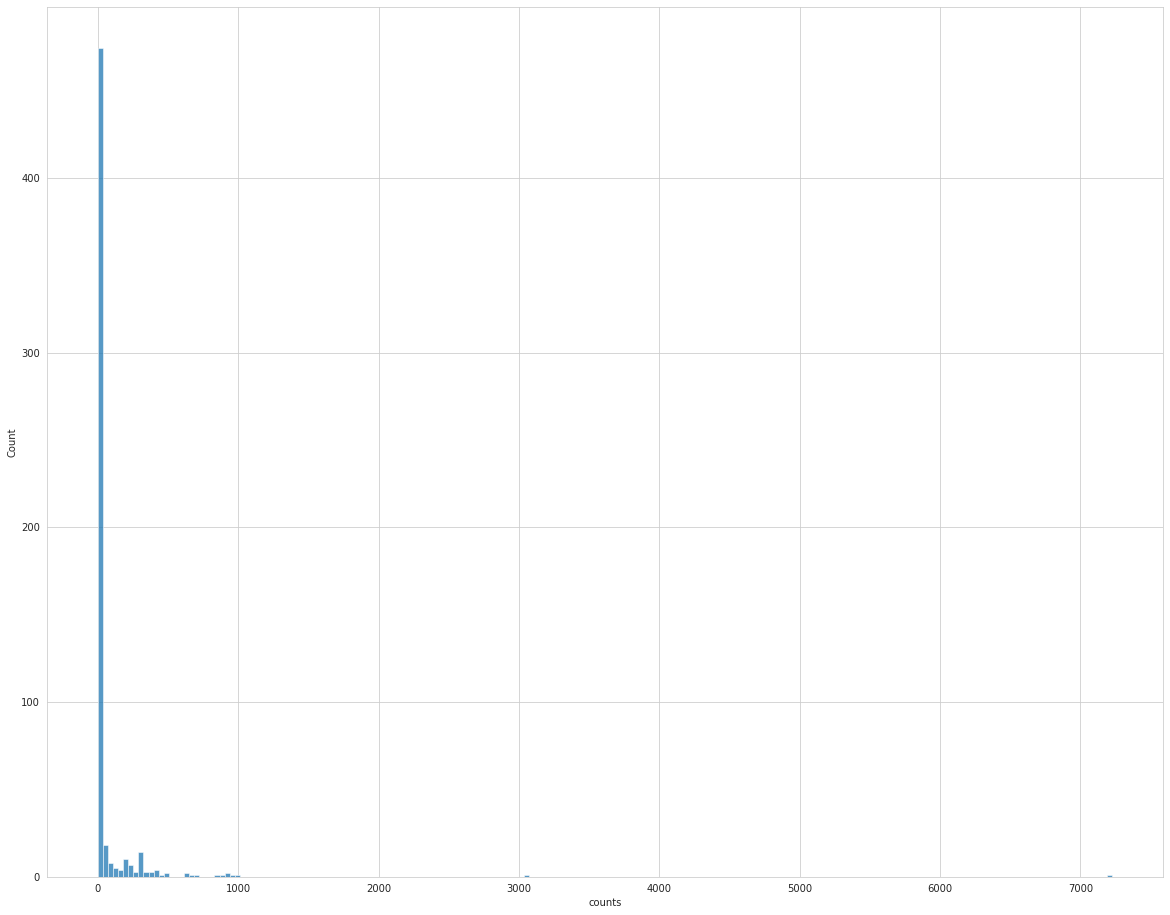

In [126]:
fig, ax = plt.subplots(nrows = 1 ,figsize=(20,16))
sns.histplot(adjusted_rates.counts, bins=200);

# Scratch pad below

Ignore....